In [1]:
using CollectiveSpins
using PyPlot
using Statistics
using JLD2
using ProgressMeter
using QuantumOptics
using OrdinaryDiffEq
using Libdl

In [2]:
""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}), du, u)
end

""" Function to pass to the solver for QC """
function fsolve(du, u, p, t)
    for i = 1:length(fnames)
        functions[i](du, u)
    end
end

fsolve

### Define the system

In [3]:
# Define geometry of system
Nx,Ny,Nz = [5,5,3]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532. # Optical lattice spacing in nm
e = [0,0,1]   # Quantization axis

# Initial values
theta_init = 0
phi_init = 0 # 1 if laser induced correlations between the atoms, 0 else

λ = 1299.
θl = 30*pi/180 # Angle of the laser

a,b,c = [d_xy,d_xy,d_z]/λ
geo = geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = SpinCollection(geo, e, gammas=1.)

Tstep, Tend = 1e-3, 1 # Normalised by Γ0
T = [0:Tstep:Tend;];

In [4]:
theta_array = ones(N)*theta_init
phi_array = prepare_phi_IS(θl, λ, theta_array)*phi_init;

### QC C functions

In [5]:
@load "op_list.jdl2" op_list
u0 = u0_CFunction(phi_array, theta_array, op_list);
Nvar = length(u0);

In [6]:
Nsubfct = 15 # Number of blocks created for the compilation
fnames = ["call_diffeq_group_$(lpad(string(i), 3, '0'))" for i = 1:Nsubfct]
libpaths = ["libs/liballfuncs$i.dll" for i = 1:Nsubfct];

In [7]:
# Prepare the wrapper
const N_FUNCS = length(fnames)  # Total function nbr
const functions = Vector{Function}(undef, N_FUNCS)
@showprogress for i in 1:N_FUNCS
    functions[i] = load_f(fnames[i], libpaths[i])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [8]:
prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
@time begin
sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
            reltol=1.0e-6,
            abstol=1.0e-8).u;
end

511.281183 seconds (6.53 M allocations: 569.550 MiB, 0.14% gc time, 0.39% compilation time)


1001-element Vector{Vector{ComplexF64}}:
 [1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.9989989249638201 - 1.093328405684471e-22im, 0.9989985265722244 + 5.816157855599432e-22im, 0.998998617691202 - 3.468217503974859e-22im, 0.9989985265722244 + 9.9984019980458e-22im, 0.9989989249638201 + 1.3799657975005813e-21im, 0.9989985265722244 + 2.7232406114728207e-22im, 0.9989980342492436 - 2.3832574103064726e-21im, 0.9989981850923252 + 4.373373678195312e-22im, 0.9989980342492436 + 2.135305330632324e-21im, 0.9989985265722244 + 1.8852722059482082e-21im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.9979956767553047 - 4.942466075345891e-22im, 0.997994102131135 + 1.56094082599831e-21im, 0.9979

In [9]:
@save "Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2))" sol

In [10]:
mean_σx_QC = [2*mean(real(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σy_QC = [2*mean(imag(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σz_QC = [2*mean(real(sol[i][1:N]))-1 for i=1:length(T)]
mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6;

# Plots

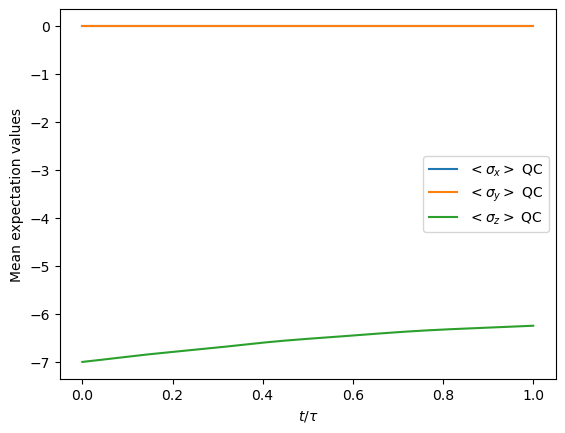

In [11]:
close("all")

plot(T, mean_σx_QC, label=L"$<\sigma_x>$ QC")
plot(T, mean_σy_QC, label=L"$<\sigma_y>$ QC")
plot(T, mean_σz67_QC, label=L"$<\sigma_z>$ QC")

xlabel(L"t/\tau")
ylabel("Mean expectation values")

legend()
pygui(false); gcf()
#pygui(true); show()